# Notebook to generate figure for initial model conditions for the wind cases. 
Show plan view processes of surface salinity, salinity gradient magnitude $\nabla_H s$, relative vorticity $\zeta/f = (\partial_x v - \partial_y u)/f$, and cross section of $u$ velocity 

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from xhistogram.xarray import histogram
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore") #The chaotic option, used to suppress issues with cf_time with xroms 

In [2]:
path1 = '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_0_f_43N/shelf_dx_500_uwind_0_f_43N_open_his.nc'
ds = xroms.open_netcdf(path1)
ds, grid = xroms.roms_dataset(ds)

In [3]:
def surface_vorticity(ds, grid):
    '''
Calculates the surface vertical vorticity normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
rvort_psi: Normalized vorticity on the psi points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudy = grid.derivative(u, 'Y')
    dudy = xroms.to_rho(dudy, grid)
    dvdx = grid.derivative(v, 'X')
    dvdx = xroms.to_rho(dvdx, grid)

    rvort_rho = (dvdx-dudy)/ds.f
    
    return rvort_rho 

def surface_saltgradmag(ds, grid):
    '''
Calculates the surface horizontal salinity gradient magnitude normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
sgradmag: horizontal salinity gradient magnitude on the psi points, to match
vorticity

    '''
    s = ds.salt.isel(s_rho=-1)

    dsdx = grid.derivative(s, 'X', boundary = 'extend')
    dsdx_psi = xroms.to_rho(dsdx, grid)
    dsdy = grid.derivative(s, 'Y', boundary = 'extend')
    dsdy_psi = xroms.to_rho(dsdy, grid)
    
    sgradmag = (dsdx_psi**2+dsdy_psi**2)**(1/2)
    
    return sgradmag

sgradmag = surface_saltgradmag(ds, grid)
rv = surface_vorticity(ds, grid)

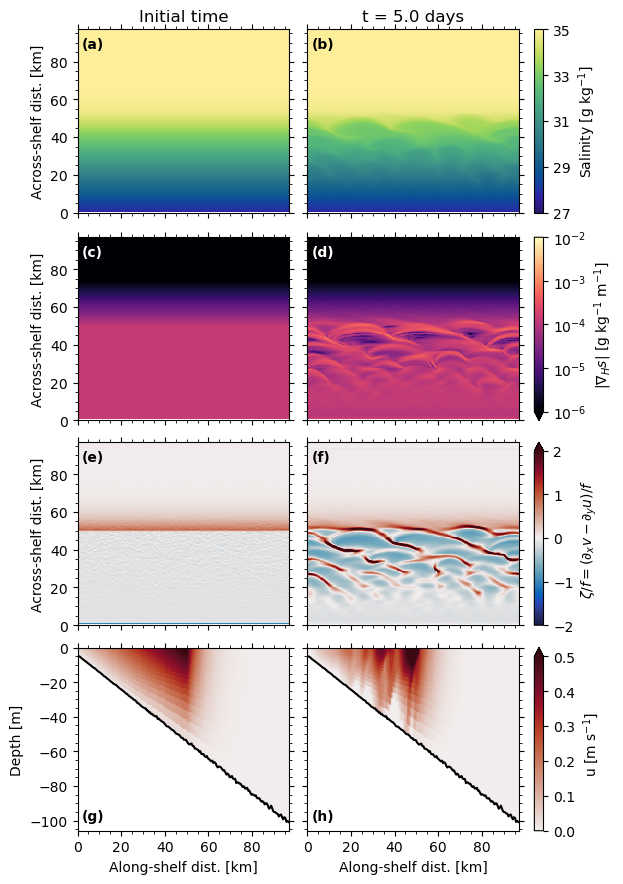

In [60]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(4,2, figsize = ((7/2)*1.75,8.732), constrained_layout = True)

#Interpolate vertical coordinate for plotting
zw_u = grid.interp(ds.z_w, 'X')
zw_u = zw_u.assign_coords({"x_u": ds.x_u})

#Plot surface salt
xrho = (ds.x_rho/1000)[1:].values
yrho = (ds.y_rho/1000)[1:].values

mappable = ax[0,0].pcolormesh(xrho, yrho, ds.salt[0,-1,1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable1 = ax[0,1].pcolormesh(xrho, yrho, ds.salt[96,-1,1:].values, cmap = cmo.haline, vmin = 27, vmax = 35)
cbar = fig.colorbar(mappable1, ax = ax[0,1], label = '', ticks = [27, 29, 31, 33, 35],)
cbar.ax.set_ylabel(r'Salinity [g kg$^{-1}$]')

#Plot salinity gradient magnitude
sfill = sgradmag[0,1:].where(sgradmag[0,1:]>1e-6)
sfill0 = sfill.fillna(value=1e-6)
sfill1 = sgradmag[96,1:].where(sgradmag[96,1:]>1e-6)
sfill01 = sfill1.fillna(value=1e-6)

mappable2 = ax[1,0].pcolormesh(xrho, yrho, np.log10(sfill0), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
mappable3 = ax[1,1].pcolormesh(xrho, yrho, np.log10(sfill01), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
cbar = fig.colorbar(mappable3, ax = ax[1,1], label = '', extend = 'min', format=tick.FormatStrFormatter('$10^{%d}$'))
cbar.ax.set_ylabel(r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]')

mappable4 = ax[2,0].pcolormesh(xrho, yrho, rv[0,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -2, vmax = 2)
mappable5 = ax[2,1].pcolormesh(xrho, yrho, rv[96,1:], cmap = plt.get_cmap('cmo.balance'), vmin = -2, vmax = 2)
cbar = fig.colorbar(mappable5, ax = ax[2,1], label = '', extend = 'max')
cbar.ax.set_ylabel(r'$\zeta/f=(\partial_x v - \partial_y u)/f$')

#Plot the u velocities 
ds.u.isel(ocean_time = 0, xi_u = 50).plot(ax = ax[3,0], x = 'y_u', y = 'z_rho_u', cmap = cmo.amp, vmin = 0, vmax = 0.5, add_colorbar = False)
zw_u.isel(ocean_time = 0, s_w = 0, xi_u = 50).plot(ax = ax[3,0], x = 'y_u', c = 'k')

uplt = ds.u.isel(ocean_time = 96, xi_u = 50).plot(ax = ax[3,1], x = 'y_u', y = 'z_rho_u', cmap = cmo.amp, vmin = 0, vmax = 0.5, add_colorbar = False)
zw_u.isel(ocean_time = 96, s_w = 0, xi_u = 50).plot(ax = ax[3,1], x = 'y_u', c = 'k')

cbar = fig.colorbar(uplt, ax = ax[3,1], label = 'u [m s$^{-1}$]', extend = 'max')

for i in range(3):
    for j in range(2):
        ax[i,j].set(xlim=[0,97], ylim=[0,97])
        ax[i,j].set_xticks(np.arange(0,100,20))
        minor_locator = AutoMinorLocator(2)
        ax[i,j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
        ax[i,j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)
        ax[i,1].set_yticklabels('')
        ax[i,j].minorticks_on()


for i in range(2):
    # ax[3,i].set_xlabel('')
    ax[0,i].set_xticklabels('')
    ax[1,i].set_xticklabels('')
    ax[2,i].set_xticklabels('')

ax[3,0].set_ylabel('Depth [m]')
ax[3,0].set_title('')
ax[3,1].set_ylabel('')
ax[3,1].set_yticklabels('')
ax[3,1].set_title('')

ax[0,0].set_ylabel('Across-shelf dist. [km]')
ax[1,0].set_ylabel('Across-shelf dist. [km]')
ax[2,0].set_ylabel('Across-shelf dist. [km]')
ax[3,0].set_ylabel('Depth [m]')
ax[3,1].set_ylabel('')
ax[3,0].set_xlabel('Along-shelf dist. [km]')
ax[3,1].set_xlabel('Along-shelf dist. [km]')

ax[0,0].text(2,87, '(a)', fontweight = 'semibold')
ax[0,1].text(2,87, '(b)', fontweight = 'semibold')
ax[1,0].text(2,87, '(c)', fontweight = 'semibold', color = 'white')
ax[1,1].text(2,87, '(d)', fontweight = 'semibold', color = 'white')
ax[2,0].text(2,87, '(e)', fontweight = 'semibold')
ax[2,1].text(2,87, '(f)', fontweight = 'semibold')
ax[3,0].text(2000,-100, '(g)', fontweight = 'semibold')
ax[3,1].text(2000,-100, '(h)', fontweight = 'semibold')
ax[0,0].set_title('Initial time')
ax[0,1].set_title('t = 5.0 days')

ax[3,0].set_xticklabels(['0', '20', '40', '60', '80'])
ax[3,1].set_xticklabels(['0', '20', '40', '60', '80'])

for i in range(2):
    ax[3,i].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
    ax[3,i].minorticks_on()

plt.savefig('initial_conditions.jpg', dpi = 300, bbox_tight= True)